# Understanding Loan Status & Classifying borrowers
#### Goals
    - Understand what factors effect loan status 
    - Create a classifer Model that borrow based on rather they will fully pay or be charged off  
#### Members
    - Laurent Mundell
    - Zaki Jefferson

### Table of content
- Import
- Links
- Load Data
- Methods/Constants/Globals
- Clean Data
- Prep Data
- Modeling
    - Logistic Regressor

# import

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

from yellowbrick.datasets import load_concrete
import warnings
from xgboost import XGBClassifier
import squarify
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Laurent\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Links

- [kaggle source](https://www.kaggle.com/zaurbegiev/my-dataset#credit_train.csv)
- [Where dat came from](https://data.gov.ie)
- [Grid Search code](https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv)

# Load Data

In [3]:
_  = os.path.join('data', 'credit_train.csv')
bank_df = pd.read_csv(_)

# Methods/Constants/Globals

In [5]:
%run -i "scripts//methods_globals_constants.py"

# Clean Data

In [6]:
%run -i "scripts//clean_data.py"

# Prep Data

In [7]:
%run -i "scripts//prep_data.py"

# Modeling

### <span style="color:blue">------------------------------------------Base Line Model Logistic Regresssion------------------------------------------ </span>

Model can only do slightly better than random guesses.

Train Accuracy 0.553125
Test Accuracy 0.54375


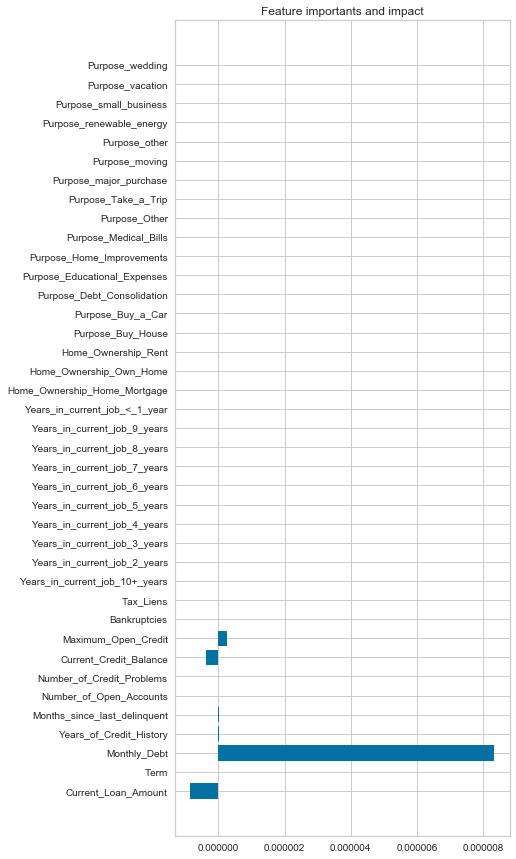

In [90]:
logr_clf = LogisticRegression()
logr_clf.fit(X_train, y_train)
y_pred = logr_clf.predict(X_train)

print('Train Accuracy', logr_clf.score(X_train, y_train))
print('Test Accuracy', logr_clf.score(X_test, y_test))


fig, ax = plt.subplots(figsize=(6, 15))
ax.barh(y=X_train.columns, width=logr_clf.coef_[0])
ax.set_title('Feature importants and impact');

### <span style="color:blue">------------------------------------------ Random Forest------------------------------------------</span>

Train Accuracy 0.7269886363636363
Test Accuracy 0.6589015151515152
OOB Score 0.648626893939394


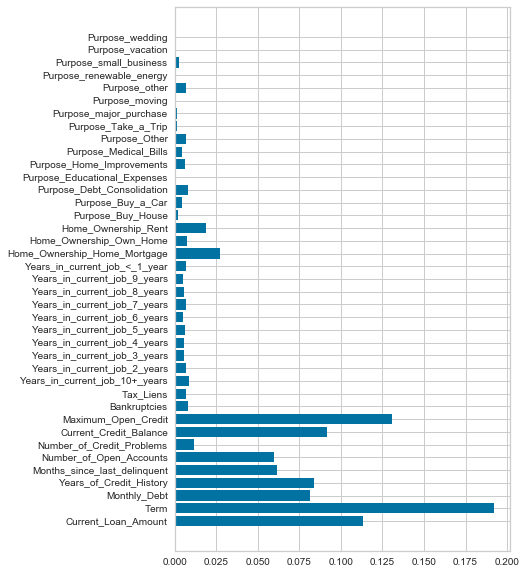

In [113]:
rf_clf = RandomForestClassifier(n_estimators= 300, 
                                criterion= 'gini', 
                                max_depth= 10, 
                                max_features= 'auto',
                                oob_score= True)
rf_clf.fit(X_train, y_train.ravel())

accuracy_train = rf_clf.score(X_train, y_train)
accuracy_test = rf_clf.score(X_test, y_test)
oob = rf_clf.oob_score_

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)
print('OOB Score', oob)

fig, ax = plt.subplots(figsize=(6, 10))
ax.bar(height=rf_clf.feature_importances_, x=X_train.columns)
plt.savefig('feature_important.png');

In [163]:
y_pred = rf_clf.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_pred, y_train).ravel()
tn, fp, fn, tp

(7357, 2547, 3219, 7997)

In [144]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
tn, fp, fn, tp 


(0, 2, 1, 1)

In [145]:
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])

array([[0, 2],
       [1, 1]], dtype=int64)

### <span style="color:blue">------------------------------------------ GradientBoostingClassifier------------------------------------------</span>

Train Accuracy 0.6442708333333333
Test Accuracy 0.6246212121212121


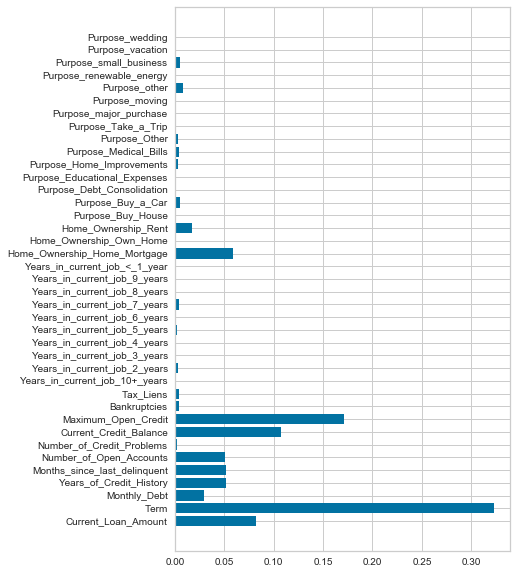

In [129]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

accuracy_train = gbc.score(X_train, y_train.ravel())
accuracy_test = gbc.score(X_test, y_test.ravel())

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)

fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(width=gbc.feature_importances_, y=X_train.columns);

### <span style="color:blue">------------------------------------------AdaBoostClassifier------------------------------------------</span>

Train Accuracy 0.618465909090909
Test Accuracy 0.6136363636363636


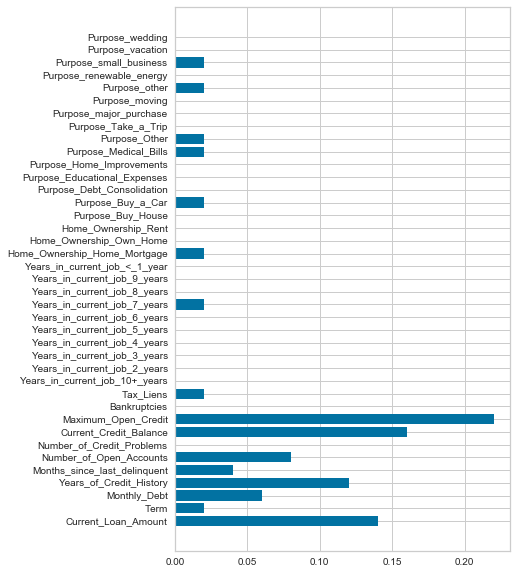

In [87]:
abc = AdaBoostClassifier(random_state=42)

abc.fit(X_train, y_train.ravel())

accuracy_train = abc.score(X_train, y_train)
accuracy_test = abc.score(X_test, y_test)

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)

fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(width=abc.feature_importances_, y=X_train.columns);

# Modeling PCA

Using principal component analysis, the number of features droped from 42 to 30 which capture ~90 of the variance of the data. We'll run the same models with the PCA data

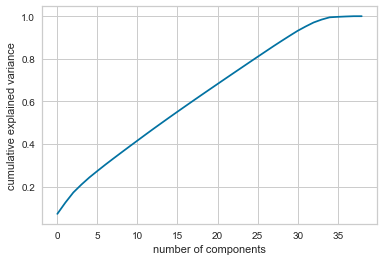

In [8]:
X_scaler = StandardScaler().fit_transform(X)
pca = PCA().fit(X_scaler)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


X_scaler = StandardScaler().fit_transform(X)
pca = PCA(n_components=34).fit(X_scaler)
principalComponents = pca.fit_transform(X)

_ = [f'PC{_}' for _ in range(1, 35)]
prince_df = pd.DataFrame(data=principalComponents, columns=_)

In [9]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(prince_df, y, test_size= 0.2)

### <span style="color:red">------------------------------------------Model Logistic Regresssion------------------------------------------ </span>

Train Accuracy 0.5529829545454545
Test Accuracy 0.5380681818181818


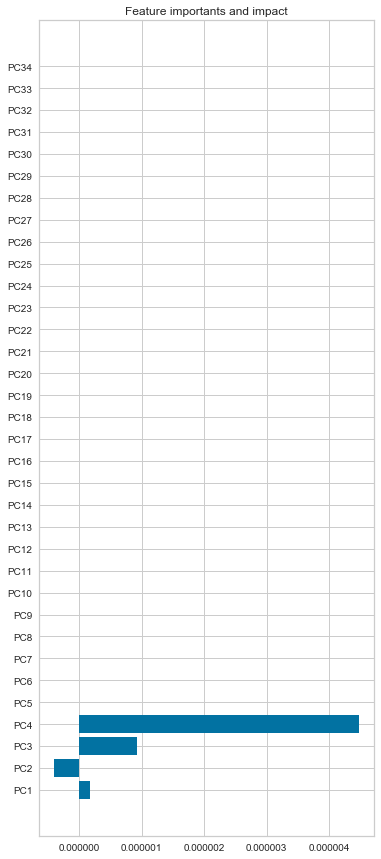

In [242]:
logr_clf = LogisticRegression()
logr_clf.fit(X_train_pca, y_train_pca)
y_pred = logr_clf.predict(X_train_pca)

print('Train Accuracy', logr_clf.score(X_train_pca, y_train_pca))
print('Test Accuracy', logr_clf.score(X_test_pca, y_test_pca))


fig, ax = plt.subplots(figsize=(6, 15))
ax.barh(y=X_train_pca.columns, width=logr_clf.coef_[0])
ax.set_title('Feature importants and impact');

### <span style="color:red">------------------------------------------ Random Forest------------------------------------------</span>

random forest improved a little bit

Train Accuracy 0.8091382575757575
Test Accuracy 0.6941287878787878
OOB Score 0.6838068181818182


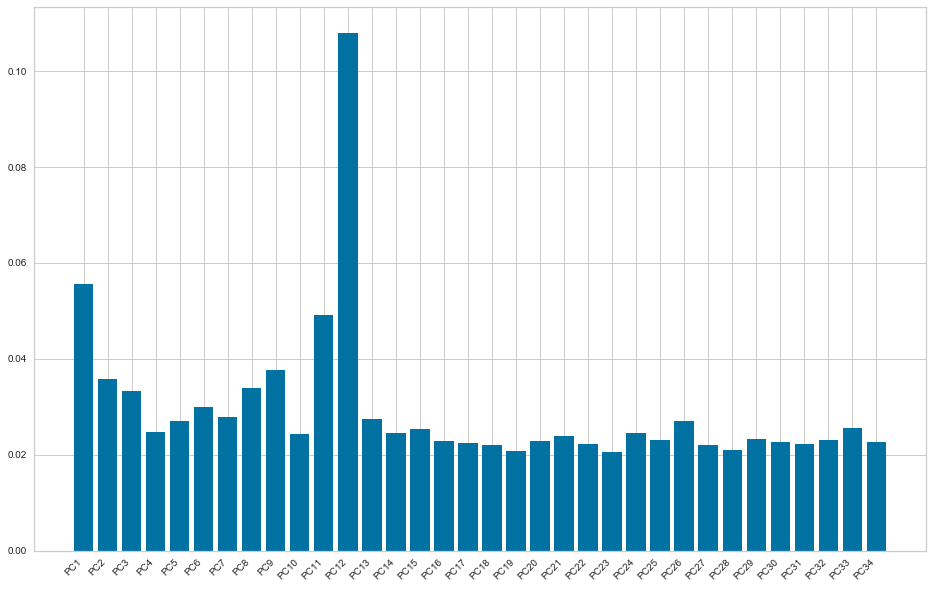

In [267]:
rf_clf = RandomForestClassifier(n_estimators= 300, 
                                criterion= 'gini', 
                                max_depth= 10, 
                                max_features= 'auto',
                                oob_score= True)
rf_clf.fit(X_train_pca, y_train_pca.ravel())

accuracy_train = rf_clf.score(X_train_pca, y_train_pca)
accuracy_test = rf_clf.score(X_test_pca, y_test_pca)
oob = rf_clf.oob_score_

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)
print('OOB Score', oob)

fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(height=rf_clf.feature_importances_, x=X_train_pca.columns)
plt.xticks(rotation=45, horizontalalignment='right');

### <span style="color:red">------------------------------------------ Gradient BoostingClassifier------------------------------------------</span>

Train Accuracy 0.4965435606060606
Test Accuracy 0.50625


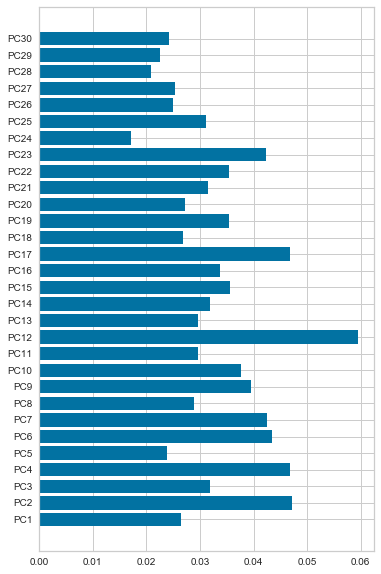

In [226]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train_pca, y_train)

accuracy_train = gbc.score(X_train_pca, y_train_pca.ravel())
accuracy_test = gbc.score(X_test_pca, y_test_pca.ravel())

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)

fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(width=gbc.feature_importances_, y=X_train_pca.columns);

### <span style="color:red">------------------------------------------ ADA BoostingClassifier------------------------------------------</span>

Train Accuracy 0.6317708333333333
Test Accuracy 0.6089015151515151


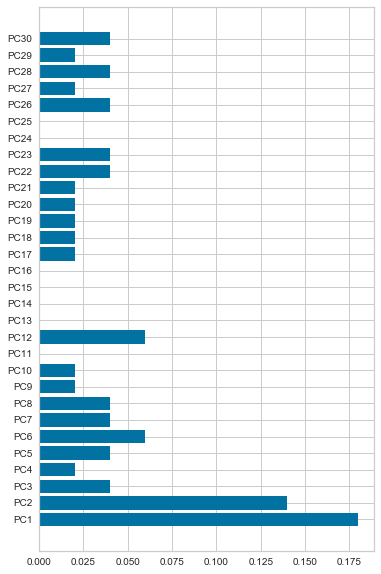

In [227]:
abc = AdaBoostClassifier(random_state=42)

abc.fit(X_train_pca, y_train_pca.ravel())

accuracy_train = abc.score(X_train_pca, y_train_pca)
accuracy_test = abc.score(X_test_pca, y_test_pca)

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)

fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(width=abc.feature_importances_, y=X_train_pca.columns);

# Grid Search 

### <span style="color:green">------------------------------------------ Random Forest------------------------------------------</span>

In [ ]:
rf_clf = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy'],
    'oob_score' : [True]
}

CV_rfc = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)